<a href="https://colab.research.google.com/github/Parv-Agarwal/Multimodal-Image-Unlearning/blob/main/Visual_anchors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops-exts

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


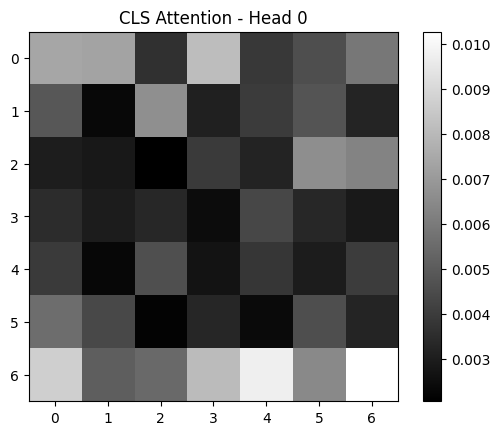

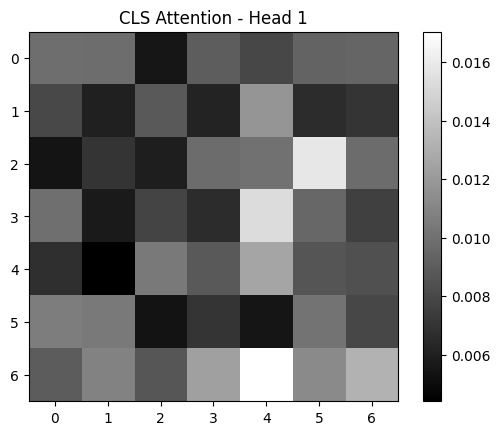

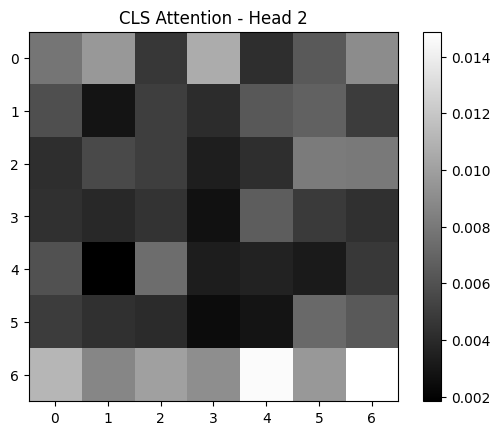

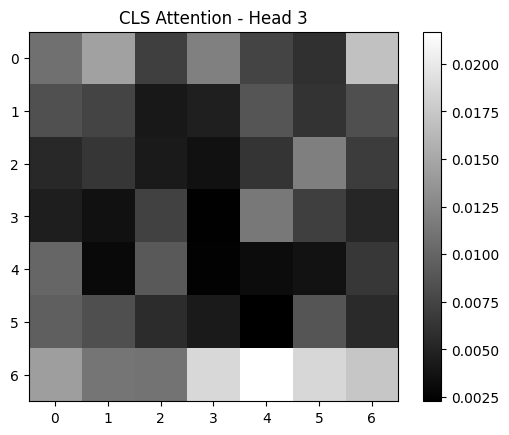

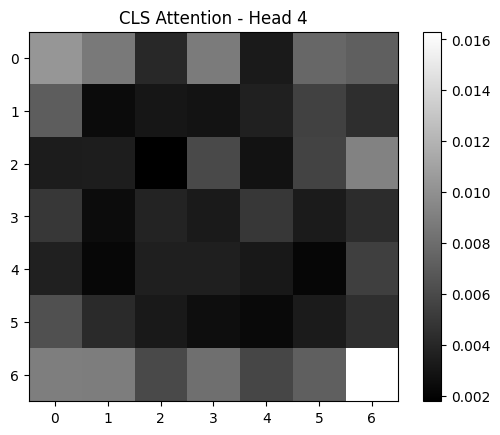

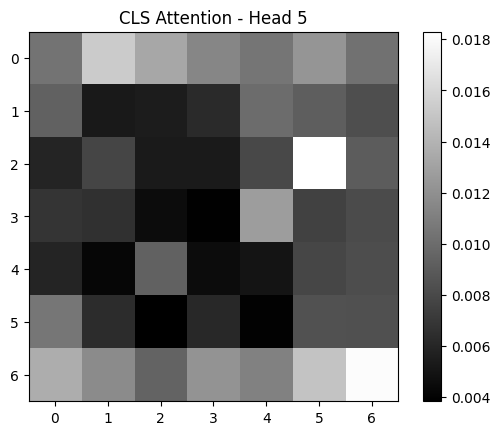

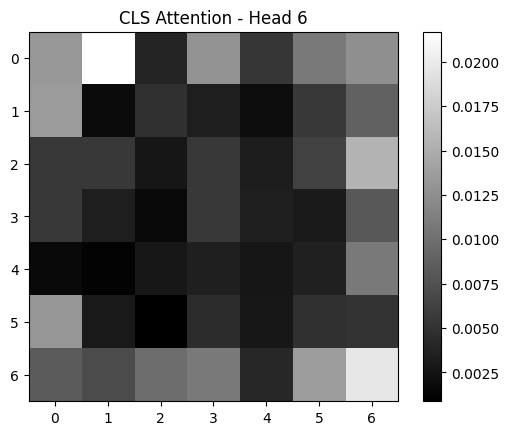

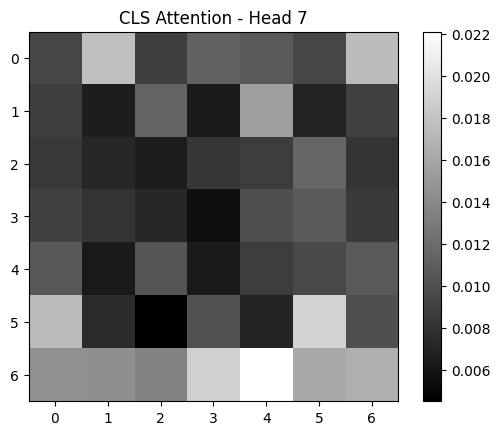

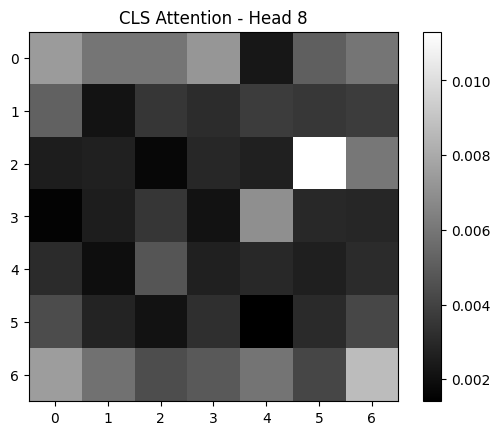

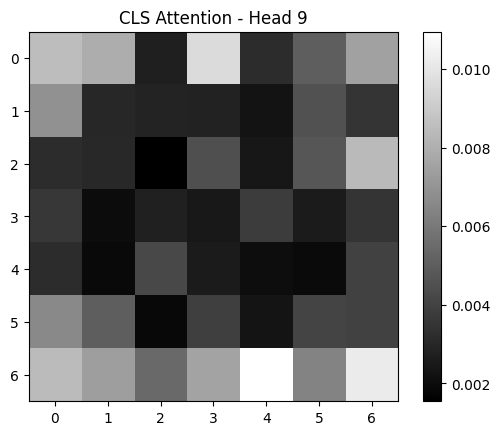

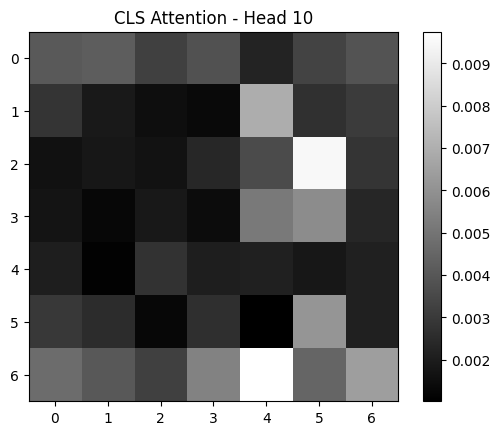

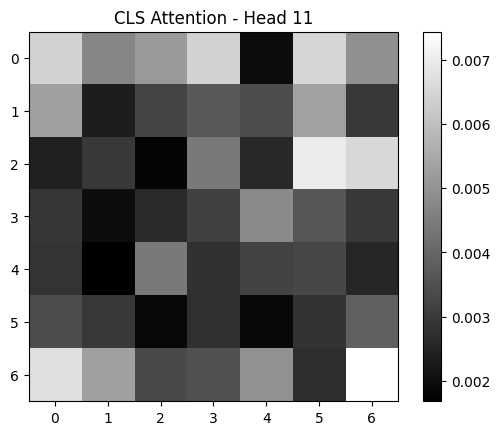

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig


class Args:
    mm_vision_select_layer = -1         # example: use last layer
    mm_vision_select_feature = 'patch'  # 'patch' or 'cls_patch'
    unfreeze_mm_vision_tower = False

class CLIPVisionTower(nn.Module):
    def __init__(self, vision_tower, args, delay_load=False):
        super().__init__()

        self.is_loaded = False
        self.vision_tower_name = vision_tower
        self.select_layer = args.mm_vision_select_layer
        self.select_feature = getattr(args, 'mm_vision_select_feature', 'patch')

        # If not delaying load, or if we want to unfreeze, load immediately
        if not delay_load:
            self.load_model()
        elif getattr(args, 'unfreeze_mm_vision_tower', False):
            self.load_model()
        else:
            # just load config for now
            self.cfg_only = CLIPVisionConfig.from_pretrained(self.vision_tower_name)

    def load_model(self, device_map=None):
        if self.is_loaded:
            print(f'{self.vision_tower_name} is already loaded, skipping.')
            return

        self.image_processor = CLIPImageProcessor.from_pretrained(self.vision_tower_name)
        self.vision_tower = CLIPVisionModel.from_pretrained(self.vision_tower_name, device_map=device_map)
        # Freeze the vision tower by default
        self.vision_tower.requires_grad_(False)

        self.is_loaded = True

    def feature_select(self, image_forward_outs):
        """
        Returns:
            image_features: full hidden states from self.select_layer, shape [batch, seq_len, hidden_dim]
            selected_query: anchor patches chosen via attention from CLS
            cls_attn_maps_per_head: shape [batch, heads, seq_len], the CLS→all-tokens attention
        """
        selected_query = None

        # 1) Get attention from the chosen layer. shape = [b, heads, seq_len, seq_len]
        attention = image_forward_outs.attentions[self.select_layer]
        # 2) Get hidden states from the chosen layer. shape = [b, seq_len, hidden_dim]
        image_features = image_forward_outs.hidden_states[self.select_layer]

        # 3) Extract CLS→all tokens attention, shape [b, heads, seq_len]
        #    (If you want only patch tokens, do attention[:, :, 0, 1:])
        cls_attn_maps_per_head = attention[:, :, 0, :]

        ################################################################
        # Anchor Selection (CLS-based)
        ################################################################
        num_count = 30;
        per_head_num = int(num_count / attention.shape[1])  # anchors per head

        # We'll select top anchors for each head, plus index 0 for CLS
        for b_idx in range(attention.shape[0]):  # iterate over batch
            max_indices = []
            for h_idx in range(attention.shape[1]):  # iterate over heads
                # attention from CLS token (0) to patch tokens (1:)
                tmp_attn = attention[b_idx, h_idx, 0, 1:]  # shape [seq_len - 1]
                # argsort ascending => the largest attention at the end
                tmp_sorted = (torch.argsort(tmp_attn) + 1).detach().cpu().tolist()  # +1 offset for skipping CLS

                # pick top per_head_num + the CLS(=0) index
                tmp_res = set(max_indices + tmp_sorted[-per_head_num:] + [0])
                count = 1
                while len(tmp_res) < (h_idx * per_head_num + per_head_num + 1):
                  tmp_res = set(max_indices + tmp_sorted[-(per_head_num + count):] + [0])
                  count += 1
                max_indices = sorted(list(tmp_res))

            # gather anchor features for the current batch element
            # shape of anchor features: [len(max_indices), hidden_dim]
            anchor_features = image_features[b_idx, max_indices, :].unsqueeze(0)  # [1, anchor_count, hidden_dim]

            if torch.is_tensor(selected_query):
                selected_query = torch.cat((selected_query, anchor_features), dim=0)  # accumulate
            else:
                selected_query = anchor_features

        return image_features, selected_query, cls_attn_maps_per_head

    @torch.no_grad()
    def forward(self, images):
        """
        Args:
            images: a torch.Tensor of shape [b, 3, H, W] or a list of such images

        Returns:
            (image_features, selected_query, cls_attn_maps_per_head)
        """
        if isinstance(images, list):
            # If images is a list, process each individually
            feats, queries, attn_maps = [], [], []
            for img in images:
                out = self.vision_tower(
                    img.to(device=self.device, dtype=self.dtype).unsqueeze(0),
                    output_hidden_states=True,
                    output_attentions=True
                )
                image_features, selected_query, cls_attn_maps = self.feature_select(out)
                feats.append(image_features.to(img.dtype))
                queries.append(selected_query.to(img.dtype))
                attn_maps.append(cls_attn_maps.to(img.dtype))
            # Return list of results in same structure
            return feats, queries, attn_maps
        else:
            # Single batched Tensor
            out = self.vision_tower(
                images.to(device=self.device, dtype=self.dtype),
                output_hidden_states=True,
                output_attentions=True
            )
            image_features, selected_query, cls_attn_maps = self.feature_select(out)
            return (
                image_features.to(images.dtype),
                selected_query.to(images.dtype),
                cls_attn_maps.to(images.dtype),
            )

    @property
    def dummy_feature(self):
        return torch.zeros(1, self.hidden_size, device=self.device, dtype=self.dtype)

    @property
    def dtype(self):
        return self.vision_tower.dtype

    @property
    def device(self):
        return self.vision_tower.device

    @property
    def config(self):
        if self.is_loaded:
            return self.vision_tower.config
        else:
            return self.cfg_only

    @property
    def hidden_size(self):
        return self.config.hidden_size

    @property
    def num_patches_per_side(self):
        return self.config.image_size // self.config.patch_size

    @property
    def num_patches(self):
        return (self.config.image_size // self.config.patch_size) ** 2

args = Args()
tower = CLIPVisionTower("openai/clip-vit-base-patch32", args)

# 2. Prepare a dummy input batch (1 image, shape [1, 3, 224, 224] for CLIP ViT-B/32)
sample_image = torch.randn(1, 3, 224, 224)

# 3. Forward pass
image_features, selected_query, cls_attn_maps_per_head = tower(sample_image)

# 4. Suppose we want to visualize the attention for head=0, just from the first image in the batch
#    If your patch layout is 24x24 => 576 patch tokens (ViT-B/32 usually has 7x7 if the default is 224 image_size
#    so you'd need to figure out the actual patch grid size from config)
#    For demonstration, let's assume 24x24 patches. Adjust as needed!
patch_side = 7

# cls_attn_maps_per_head shape = [batch, heads, seq_len]
# If you want CLS -> patch tokens only, excluding CLS:
# shape becomes [batch, heads, seq_len - 1]
# (Adjust indexing if your model is actually 7x7 or 14x14 patches, etc.)
cls_attn_maps_no_cls = cls_attn_maps_per_head[:, :, 1:]  # [b, heads, seq_len-1]
for i in range(cls_attn_maps_no_cls.shape[1]):
    head_idx = i
    attn_map_1d = cls_attn_maps_no_cls[0, head_idx]  # shape [seq_len-1]

    # If you know the patch layout is patch_side x patch_side => flatten
    # reshape to 2D
    attn_map_2d = attn_map_1d.reshape(patch_side, patch_side).detach().cpu().numpy()

    # 5. Plot
    plt.imshow(attn_map_2d, cmap='gray')
    plt.title(f"CLS Attention - Head {head_idx}")
    plt.colorbar()
    plt.show()
